In [0]:
%sql
SELECT * FROM precificacao.db_precificacao.base_precificacao LIMIT 5

Data,Produto,Preco_Atual,Demanda,Estoque,Concorrencia,Sazonalidade
2023-01-01,Camiseta Básica,49.9,180,1200,48.5,Baixa
2023-02-01,Camiseta Básica,51.5,160,1020,49.0,Baixa
2023-03-01,Camiseta Básica,50.0,220,800,50.5,Média
2023-04-01,Camiseta Básica,52.0,250,550,51.2,Média
2023-05-01,Camiseta Básica,50.5,210,340,49.8,Média


In [0]:
%sql
SELECT 
  COUNT(*) as total_registros,
  COUNT(DISTINCT Produto) as tipos_produtos,
  MIN(Data) as data_inicio,
  MAX(Data) as data_fim
FROM precificacao.db_precificacao.base_precificacao

total_registros,tipos_produtos,data_inicio,data_fim
120,5,2023-01-01,2024-12-01


In [0]:
%sql
SELECT 
  Produto,
  COUNT(*) as registros,
  AVG(Preco_Atual) as preco_medio,
  AVG(Demanda) as demanda_media,
  AVG(Concorrencia) as concorrencia_media
FROM precificacao.db_precificacao.base_precificacao
GROUP BY Produto

Produto,registros,preco_medio,demanda_media,concorrencia_media
Moletom com Capuz,24,129.99583333333334,272.0833333333333,128.4375
Tênis Esportivo,24,283.70416666666665,172.91666666666666,281.9166666666667
Calça Jeans,24,158.47083333333333,189.16666666666666,158.0375
Camiseta Básica,24,54.387499999999996,333.75,53.46666666666666
Boné de Aba Reta,24,48.49166666666667,277.9166666666667,48.09583333333333


In [0]:
%sql
SELECT
  COUNT(*) - COUNT(Data) AS nulos_Data,
  COUNT(*) - COUNT(Produto) AS nulos_Produto,
  COUNT(*) - COUNT(Preco_Atual) AS nulos_Preco_Atual,
  COUNT(*) - COUNT(Demanda) AS nulos_Demanda,
  COUNT(*) - COUNT(Estoque) AS nulos_Estoque,
  COUNT(*) - COUNT(Concorrencia) AS nulos_Concorrencia,
  COUNT(*) - COUNT(Sazonalidade) AS nulos_Sazonalidade
FROM precificacao.db_precificacao.base_precificacao;

nulos_Data,nulos_Produto,nulos_Preco_Atual,nulos_Demanda,nulos_Estoque,nulos_Concorrencia,nulos_Sazonalidade
0,0,0,0,0,0,0


In [0]:
%sql
SELECT *
FROM precificacao.db_precificacao.base_precificacao
WHERE 
  Data IS NULL OR
  Produto IS NULL OR
  Preco_Atual IS NULL OR
  Demanda IS NULL OR
  Estoque IS NULL OR
  Concorrencia IS NULL OR
  Sazonalidade IS NULL;

Data,Produto,Preco_Atual,Demanda,Estoque,Concorrencia,Sazonalidade


In [0]:
%sql
SELECT
  'Preco_Atual' as Metrica,
  COUNT(Preco_Atual) as Contagem,
  ROUND(AVG(Preco_Atual), 2) as Media,
  ROUND(STDDEV(Preco_Atual), 2) as Desvio_Padrao,
  ROUND(MIN(Preco_Atual), 2) as Minimo,
  ROUND(MAX(Preco_Atual), 2) as Maximo,
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Preco_Atual), 2) as Mediana
FROM precificacao.db_precificacao.base_precificacao

UNION ALL

SELECT
  'Demanda' as Metrica,
  COUNT(Demanda),
  ROUND(AVG(Demanda), 2),
  ROUND(STDDEV(Demanda), 2),
  ROUND(MIN(Demanda), 2),
  ROUND(MAX(Demanda), 2),
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Demanda), 2)
FROM precificacao.db_precificacao.base_precificacao

UNION ALL

SELECT
  'Estoque' as Metrica,
  COUNT(Estoque),
  ROUND(AVG(Estoque), 2),
  ROUND(STDDEV(Estoque), 2),
  ROUND(MIN(Estoque), 2),
  ROUND(MAX(Estoque), 2),
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Estoque), 2)
FROM precificacao.db_precificacao.base_precificacao

UNION ALL

SELECT
  'Concorrencia' as Metrica,
  COUNT(Concorrencia),
  ROUND(AVG(Concorrencia), 2),
  ROUND(STDDEV(Concorrencia), 2),
  ROUND(MIN(Concorrencia), 2),
  ROUND(MAX(Concorrencia), 2),
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Concorrencia), 2)
FROM precificacao.db_precificacao.base_precificacao;

Metrica,Contagem,Media,Desvio_Padrao,Minimo,Maximo,Mediana
Preco_Atual,120,135.01,87.15,39.9,340.0,130.0
Demanda,120,249.17,130.35,75.0,650.0,220.0
Estoque,120,355.21,315.43,0.0,1200.0,345.0
Concorrencia,120,133.99,86.73,40.5,335.0,128.0


In [0]:
%sql
DESCRIBE precificacao.db_precificacao.base_precificacao

col_name,data_type,comment
Data,date,null
Produto,string,null
Preco_Atual,double,null
Demanda,bigint,null
Estoque,bigint,null
Concorrencia,double,null
Sazonalidade,string,null


In [0]:
%sql
-- Criação da camada Silver como uma temporary view
-- Isto permite trabalhar com os dados tratados sem criar uma nova tabela física

CREATE OR REPLACE TEMPORARY VIEW base_precificacao_silver AS
SELECT
  Data,
  CAST(YEAR(Data) AS INT) as ano,
  CAST(MONTH(Data) AS INT) as mes,
  Produto,
  CAST(Preco_Atual AS DOUBLE) as preco_atual,
  CAST(Demanda AS INT) as demanda,
  CAST(Estoque AS INT) as estoque,
  CAST(Concorrencia AS DOUBLE) as preco_concorrencia,
  Sazonalidade,
  -- Criação de flags úteis para análise
  CASE WHEN Estoque < 100 THEN 1 ELSE 0 END as estoque_baixo,
  CASE WHEN Demanda > 200 THEN 1 ELSE 0 END as demanda_alta,
  -- Diferença entre nosso preço e concorrência
  CAST((Preco_Atual - Concorrencia) AS DOUBLE) as diferenca_vs_concorrencia
FROM precificacao.db_precificacao.base_precificacao
-- Ordenando por produto e data para melhor visualização
ORDER BY Produto, Data;

In [0]:
%sql
-- Criação da camada Silver com data de carga
CREATE OR REPLACE TEMPORARY VIEW base_precificacao_silver AS
SELECT
  Data,
  CAST(YEAR(Data) AS INT) as ano,
  CAST(MONTH(Data) AS INT) as mes,
  Produto,
  CAST(Preco_Atual AS DOUBLE) as preco_atual,
  CAST(Demanda AS INT) as demanda,
  CAST(Estoque AS INT) as estoque,
  CAST(Concorrencia AS DOUBLE) as preco_concorrencia,
  Sazonalidade,
  -- Criação de flags úteis para análise
  CASE WHEN Estoque < 100 THEN 1 ELSE 0 END as estoque_baixo,
  CASE WHEN Demanda > 200 THEN 1 ELSE 0 END as demanda_alta,
  -- Diferença entre nosso preço e concorrência
  CAST((Preco_Atual - Concorrencia) AS DOUBLE) as diferenca_vs_concorrencia,
  -- Data e hora da carga (muito importante para rastreabilidade)
  CURRENT_TIMESTAMP() as data_carga
FROM precificacao.db_precificacao.base_precificacao
ORDER BY Produto, Data;

In [0]:
%sql
-- Verificando a estrutura da silver com a nova coluna
SELECT * FROM base_precificacao_silver LIMIT 5;

Data,ano,mes,Produto,preco_atual,demanda,estoque,preco_concorrencia,Sazonalidade,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,data_carga
2023-01-01,2023,1,Boné de Aba Reta,39.9,150,700,42.0,Baixa,0,0,-2.1000000000000014,2025-09-05T18:25:24.944Z
2023-02-01,2023,2,Boné de Aba Reta,41.0,130,570,40.5,Baixa,0,0,0.5,2025-09-05T18:25:24.944Z
2023-03-01,2023,3,Boné de Aba Reta,43.0,180,390,42.5,Média,0,0,0.5,2025-09-05T18:25:24.944Z
2023-04-01,2023,4,Boné de Aba Reta,45.0,210,180,44.5,Média,0,1,0.5,2025-09-05T18:25:24.944Z
2023-05-01,2023,5,Boné de Aba Reta,44.0,190,900,43.8,Média,0,0,0.20000000000000284,2025-09-05T18:25:24.944Z


In [0]:
%sql
-- Análise de Qualidade da Camada Silver
-- 1. Verificação de valores nulos após transformações
SELECT
  COUNT(*) - COUNT(ano) as nulos_ano,
  COUNT(*) - COUNT(mes) as nulos_mes, 
  COUNT(*) - COUNT(preco_atual) as nulos_preco,
  COUNT(*) - COUNT(demanda) as nulos_demanda,
  COUNT(*) - COUNT(estoque) as nulos_estoque,
  COUNT(*) - COUNT(preco_concorrencia) as nulos_concorrencia,
  COUNT(*) - COUNT(estoque_baixo) as nulos_estoque_baixo,
  COUNT(*) - COUNT(demanda_alta) as nulos_demanda_alta,
  COUNT(*) - COUNT(data_carga) as nulos_data_carga
  FROM base_precificacao_silver;

nulos_ano,nulos_mes,nulos_preco,nulos_demanda,nulos_estoque,nulos_concorrencia,nulos_estoque_baixo,nulos_demanda_alta,nulos_data_carga
0,0,0,0,0,0,0,0,0


In [0]:
%sql
-- 2. Análise das novas features criadas
SELECT
  'estoque_baixo' as feature,
  COUNT(CASE WHEN estoque_baixo = 1 THEN 1 END) as qtd_verdadeiro,
  COUNT(CASE WHEN estoque_baixo = 0 THEN 1 END) as qtd_falso,
  ROUND(COUNT(CASE WHEN estoque_baixo = 1 THEN 1 END) * 100.0 / COUNT(*), 2) as percentual_verdadeiro
FROM base_precificacao_silver

UNION ALL

SELECT
  'demanda_alta' as feature,
  COUNT(CASE WHEN demanda_alta = 1 THEN 1 END) as qtd_verdadeiro,
  COUNT(CASE WHEN demanda_alta = 0 THEN 1 END) as qtd_falso,
  ROUND(COUNT(CASE WHEN demanda_alta = 1 THEN 1 END) * 100.0 / COUNT(*), 2) as percentual_verdadeiro
FROM base_precificacao_silver;

feature,qtd_verdadeiro,qtd_falso,percentual_verdadeiro
estoque_baixo,37,83,30.83
demanda_alta,64,56,53.33


In [0]:
%sql
-- Análise da diferença de preços vs concorrência e outras métricas
SELECT
  ROUND(MIN(diferenca_vs_concorrencia), 2) as diff_minima,
  ROUND(MAX(diferenca_vs_concorrencia), 2) as diff_maxima,
  ROUND(AVG(diferenca_vs_concorrencia), 2) as diff_media,
  ROUND(STDDEV(diferenca_vs_concorrencia), 2) as diff_desvio_padrao,
  ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY diferenca_vs_concorrencia), 2) as diff_q1,
  ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY diferenca_vs_concorrencia), 2) as diff_mediana,
  ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY diferenca_vs_concorrencia), 2) as diff_q3
FROM base_precificacao_silver;

diff_minima,diff_maxima,diff_media,diff_desvio_padrao,diff_q1,diff_mediana,diff_q3
-5.1,5.0,1.02,1.51,0.5,1.0,2.0


In [0]:
%sql
-- Criação da Camada Gold com data_carga
CREATE OR REPLACE TABLE precificacao.db_precificacao.base_precificacao_gold AS

SELECT
  -- Features temporais
  Data,
  ano,
  mes,
  
  -- Encoding do Produto (Label Encoding)
  CASE 
    WHEN Produto = 'Camiseta Básica' THEN 1
    WHEN Produto = 'Calça Jeans' THEN 2
    WHEN Produto = 'Tênis Esportivo' THEN 3
    WHEN Produto = 'Moletom com Capuz' THEN 4
    WHEN Produto = 'Boné de Aba Reta' THEN 5
  END as produto_encoded,
  
  -- Variáveis numéricas originais
  preco_atual,
  demanda,
  estoque,
  preco_concorrencia,
  
  -- Encoding da Sazonalidade (Label Encoding)
  CASE 
    WHEN Sazonalidade = 'Baixa' THEN 1
    WHEN Sazonalidade = 'Média' THEN 2
    WHEN Sazonalidade = 'Alta' THEN 3
    WHEN Sazonalidade = 'Black Friday' THEN 4
  END as sazonalidade_encoded,
  
  -- Flags business (já criadas na Silver)
  estoque_baixo,
  demanda_alta,
  diferenca_vs_concorrencia,
  
  -- Novas features avançadas
  TRY_DIVIDE(demanda, estoque) as taxa_rotatividade,
  TRY_DIVIDE((preco_atual - preco_concorrencia), preco_concorrencia) as percentual_diferenca_concorrencia,
  
  -- Data de carga da Silver (rastreabilidade)
  data_carga

FROM base_precificacao_silver
ORDER BY Data, produto_encoded;

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM precificacao.db_precificacao.base_precificacao_gold;

Data,ano,mes,produto_encoded,preco_atual,demanda,estoque,preco_concorrencia,sazonalidade_encoded,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,taxa_rotatividade,percentual_diferenca_concorrencia,data_carga
2023-01-01,2023,1,1,49.9,180,1200,48.5,1,0,0,1.3999999999999986,0.15,0.02886597938144327,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,2,149.9,90,600,155.0,1,0,0,-5.099999999999994,0.15,-0.03290322580645157,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,3,249.9,75,450,255.0,1,0,0,-5.099999999999994,0.16666666666666666,-0.019999999999999976,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,4,99.9,80,900,105.0,1,0,0,-5.099999999999994,0.08888888888888889,-0.048571428571428515,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,5,39.9,150,700,42.0,1,0,0,-2.1000000000000014,0.21428571428571427,-0.05000000000000003,2025-09-05T18:25:36.341Z
2023-02-01,2023,2,1,51.5,160,1020,49.0,1,0,0,2.5,0.1568627450980392,0.05102040816326531,2025-09-05T18:25:36.341Z
2023-02-01,2023,2,2,145.0,110,490,148.0,1,0,0,-3.0,0.22448979591836735,-0.02027027027027027,2025-09-05T18:25:36.341Z
2023-02-01,2023,2,3,255.0,85,365,250.0,1,0,0,5.0,0.2328767123287671,0.02,2025-09-05T18:25:36.341Z
2023-02-01,2023,2,4,105.0,90,810,102.5,1,0,0,2.5,0.1111111111111111,0.024390243902439025,2025-09-05T18:25:36.341Z
2023-02-01,2023,2,5,41.0,130,570,40.5,1,0,0,0.5,0.22807017543859648,0.012345679012345678,2025-09-05T18:25:36.341Z


In [0]:
%sql
SHOW TABLES IN precificacao.db_precificacao;

database,tableName,isTemporary
db_precificacao,base_precificacao,false
db_precificacao,base_precificacao_gold,false
,_sqldf,true
,base_precificacao_silver,true


In [0]:
%sql
-- Estatísticas descritivas da Gold Layer
SELECT 
  COUNT(*) as total_registros,
  COUNT(DISTINCT produto_encoded) as produtos_distintos,
  COUNT(DISTINCT sazonalidade_encoded) as sazonalidades_distintas,
  MIN(Data) as data_inicio,
  MAX(Data) as data_fim
FROM precificacao.db_precificacao.base_precificacao_gold;

total_registros,produtos_distintos,sazonalidades_distintas,data_inicio,data_fim
120,5,4,2023-01-01,2024-12-01


In [0]:
%sql
SELECT * FROM precificacao.db_precificacao.base_precificacao_gold LIMIT 3;

Data,ano,mes,produto_encoded,preco_atual,demanda,estoque,preco_concorrencia,sazonalidade_encoded,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,taxa_rotatividade,percentual_diferenca_concorrencia,data_carga
2023-01-01,2023,1,1,49.9,180,1200,48.5,1,0,0,1.3999999999999986,0.15,0.02886597938144327,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,2,149.9,90,600,155.0,1,0,0,-5.099999999999994,0.15,-0.03290322580645157,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,3,249.9,75,450,255.0,1,0,0,-5.099999999999994,0.16666666666666666,-0.019999999999999976,2025-09-05T18:25:36.341Z


In [0]:
# Primeiro, vamos carregar os dados da Gold Layer para um DataFrame
gold_df = spark.table("precificacao.db_precificacao.base_precificacao_gold")

# Agora vamos converter para Pandas para usar com Scikit-learn
# (Como temos apenas 120 linhas, podemos fazer isso tranquilamente)
pandas_df = gold_df.toPandas()

# Visualizar as primeiras linhas para confirmar
print("Primeiras 5 linhas da Gold Layer:")
display(pandas_df.head(5))

Primeiras 5 linhas da Gold Layer:


Data,ano,mes,produto_encoded,preco_atual,demanda,estoque,preco_concorrencia,sazonalidade_encoded,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,taxa_rotatividade,percentual_diferenca_concorrencia,data_carga
2023-01-01,2023,1,1,49.9,180,1200,48.5,1,0,0,1.3999999999999986,0.15,0.02886597938144327,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,2,149.9,90,600,155.0,1,0,0,-5.099999999999994,0.15,-0.03290322580645157,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,3,249.9,75,450,255.0,1,0,0,-5.099999999999994,0.16666666666666666,-0.019999999999999976,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,4,99.9,80,900,105.0,1,0,0,-5.099999999999994,0.08888888888888889,-0.048571428571428515,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,5,39.9,150,700,42.0,1,0,0,-2.1000000000000014,0.21428571428571427,-0.05000000000000003,2025-09-05T18:25:36.341Z


In [0]:
# Recriando o DataFrame desde o início
from pyspark.sql import SparkSession

# Certificar que temos uma sessão Spark
spark = SparkSession.builder.appName("PrecificacaoML").getOrCreate()

# Carregar os dados da Gold Layer
gold_df = spark.table("precificacao.db_precificacao.base_precificacao_gold")

# Converter para Pandas DataFrame
pandas_df = gold_df.toPandas()

# Verificar se funcionou
print("DataFrame criado com sucesso!")
print(f"Formato do DataFrame: {pandas_df.shape}")
print(f"Colunas disponíveis: {list(pandas_df.columns)}")

# Mostrar as primeiras linhas
display(pandas_df.head(3))

DataFrame criado com sucesso!
Formato do DataFrame: (120, 15)
Colunas disponíveis: ['Data', 'ano', 'mes', 'produto_encoded', 'preco_atual', 'demanda', 'estoque', 'preco_concorrencia', 'sazonalidade_encoded', 'estoque_baixo', 'demanda_alta', 'diferenca_vs_concorrencia', 'taxa_rotatividade', 'percentual_diferenca_concorrencia', 'data_carga']


Data,ano,mes,produto_encoded,preco_atual,demanda,estoque,preco_concorrencia,sazonalidade_encoded,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,taxa_rotatividade,percentual_diferenca_concorrencia,data_carga
2023-01-01,2023,1,1,49.9,180,1200,48.5,1,0,0,1.3999999999999986,0.15,0.02886597938144327,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,2,149.9,90,600,155.0,1,0,0,-5.099999999999994,0.15,-0.03290322580645157,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,3,249.9,75,450,255.0,1,0,0,-5.099999999999994,0.16666666666666666,-0.019999999999999976,2025-09-05T18:25:36.341Z


In [0]:
# Importar a função para dividir os dados
from sklearn.model_selection import train_test_split

# Primeiro, vamos definir nossas variáveis:
# X = Variáveis que usaremos para fazer a previsão (features)
# y = Variável que queremos prever (target)

# Todas as colunas EXCETO 'preco_atual' e 'Data' (e 'data_carga' se existir)
features = [col for col in pandas_df.columns if col not in ['preco_atual', 'Data', 'data_carga']]

X = pandas_df[features]  # Variáveis preditoras
y = pandas_df['preco_atual']  # Variável alvo (o preço que queremos prever)

# Agora dividimos os dados: 80% para treino, 20% para teste
# random_state=42 garante que a divisão seja reproduzível
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Vamos verificar o tamanho de cada conjunto
print(f"Formato dos dados:")
print(f"X_treino: {X_treino.shape}")
print(f"X_teste:  {X_teste.shape}")
print(f"y_treino: {y_treino.shape}")
print(f"y_teste:  {y_teste.shape}")

# Mostrar as primeiras linhas dos dados de treino
print("\n🔍 Primeiras linhas dos dados de treino (X_treino):")
display(X_treino.head(3))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff862b88ccc0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Formato dos dados:
X_treino: (96, 12)
X_teste:  (24, 12)
y_treino: (96,)
y_teste:  (24,)

🔍 Primeiras linhas dos dados de treino (X_treino):


ano,mes,produto_encoded,demanda,estoque,preco_concorrencia,sazonalidade_encoded,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,taxa_rotatividade,percentual_diferenca_concorrencia
2023,9,3,190,20,288.0,3,1,0,2.0,9.5,0.006944444444444444
2023,3,3,100,265,258.0,2,0,0,1.0,0.37735849056603776,0.003875968992248062
2023,4,1,250,550,51.2,2,0,1,0.7999999999999972,0.45454545454545453,0.015624999999999944


In [0]:
# Agora sim, vamos fazer a divisão dos dados
from sklearn.model_selection import train_test_split

# Verificar todas as colunas disponíveis
print(" Colunas no DataFrame:")
for col in pandas_df.columns:
    print(f"  - {col}")

# Definir features (X) e target (y)
# Vamos usar todas as colunas exceto as que não são features
features = [col for col in pandas_df.columns if col not in ['preco_atual', 'Data', 'data_carga']]

print(f"\n Features selecionadas: {features}")

X = pandas_df[features]  # Variáveis preditoras
y = pandas_df['preco_atual']  # Variável alvo

# Dividir os dados
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, 
    test_size=0.2,       # 20% para teste
    random_state=42,     # Semente para reproducibilidade
    shuffle=True         # Embaralhar os dados antes de dividir
)

# Verificar os resultados
print(f"\n Divisão concluída:")
print(f"X_treino: {X_treino.shape}")
print(f"X_teste:  {X_teste.shape}")
print(f"y_treino: {y_treino.shape}")
print(f"y_teste:  {y_teste.shape}")

print("\n Dados preparados para o modelo de Machine Learning!")

 Colunas no DataFrame:
  - Data
  - ano
  - mes
  - produto_encoded
  - preco_atual
  - demanda
  - estoque
  - preco_concorrencia
  - sazonalidade_encoded
  - estoque_baixo
  - demanda_alta
  - diferenca_vs_concorrencia
  - taxa_rotatividade
  - percentual_diferenca_concorrencia
  - data_carga

 Features selecionadas: ['ano', 'mes', 'produto_encoded', 'demanda', 'estoque', 'preco_concorrencia', 'sazonalidade_encoded', 'estoque_baixo', 'demanda_alta', 'diferenca_vs_concorrencia', 'taxa_rotatividade', 'percentual_diferenca_concorrencia']

 Divisão concluída:
X_treino: (96, 12)
X_teste:  (24, 12)
y_treino: (96,)
y_teste:  (24,)

 Dados preparados para o modelo de Machine Learning!


In [0]:
# Verificar quantos valores NaN temos em cada coluna
print(" Valores NaN por coluna:")
print(pandas_df.isnull().sum())

# Solução 1: Preencher NaN com valor específico
# Para taxa_rotatividade: quando estoque é 0, taxa é 0
pandas_df['taxa_rotatividade'] = pandas_df['taxa_rotatividade'].fillna(0)

# Solução 2: Preencher outras colunas NaN com a média
# Vamos identificar outras colunas com NaN
colunas_com_nan = pandas_df.columns[pandas_df.isnull().any()].tolist()
print(f"\n Colunas com NaN: {colunas_com_nan}")

for coluna in colunas_com_nan:
    if coluna != 'taxa_rotatividade':  # Já tratamos essa
        media = pandas_df[coluna].mean()
        pandas_df[coluna] = pandas_df[coluna].fillna(media)
        print(f" Coluna '{coluna}': NaN preenchidos com média {media:.2f}")

# Verificar se ainda existem NaN
print(f"\n Valores NaN após tratamento:")
print(pandas_df.isnull().sum())

# Agora vamos recriar X e y com dados limpos
features = [col for col in pandas_df.columns if col not in ['preco_atual', 'Data', 'data_carga']]
X = pandas_df[features]
y = pandas_df['preco_atual']

# Refazer a divisão dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"\n Dados limpos e divididos:")
print(f"X_treino: {X_treino.shape}")
print(f"X_teste:  {X_teste.shape}")

 Valores NaN por coluna:
Data                                  0
ano                                   0
mes                                   0
produto_encoded                       0
preco_atual                           0
demanda                               0
estoque                               0
preco_concorrencia                    0
sazonalidade_encoded                  0
estoque_baixo                         0
demanda_alta                          0
diferenca_vs_concorrencia             0
taxa_rotatividade                    32
percentual_diferenca_concorrencia     0
data_carga                            0
dtype: int64

 Colunas com NaN: []

 Valores NaN após tratamento:
Data                                 0
ano                                  0
mes                                  0
produto_encoded                      0
preco_atual                          0
demanda                              0
estoque                              0
preco_concorrencia                  

# MODELO 1 - Com vazamento de dados (resultados irreais)

In [0]:
# Primeiro, vamos importar o modelo de Regressão Linear
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Criar o modelo
modelo_lr = LinearRegression()

print(" Treinando o modelo de Regressão Linear...")

# 2. Treinar o modelo com os dados de TREINO
modelo_lr.fit(X_treino, y_treino)

print("Modelo treinado com sucesso!")

# 3. Fazer previsões nos dados de TESTE
y_previsto = modelo_lr.predict(X_teste)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_teste, y_previsto)
mse = mean_squared_error(y_teste, y_previsto)
rmse = np.sqrt(mse)
r2 = r2_score(y_teste, y_previsto)

print("\n RESULTADOS DO MODELO:")
print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
print(f"MSE (Erro Quadrático Médio): {mse:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")

# 5. Mostrar comparação entre previsões e valores reais
print("\n Comparação: Previsão vs Real (primeiras 10 amostras)")
comparacao = pd.DataFrame({
    'Real': y_teste.values[:10],
    'Previsto': y_previsto[:10],
    'Diferença': y_previsto[:10] - y_teste.values[:10]
})
display(comparacao)

 Treinando o modelo de Regressão Linear...
Modelo treinado com sucesso!

 RESULTADOS DO MODELO:
MAE (Erro Absoluto Médio): 0.00
MSE (Erro Quadrático Médio): 0.00
RMSE (Raiz do Erro Quadrático Médio): 0.00
R² (Coeficiente de Determinação): 1.0000

 Comparação: Previsão vs Real (primeiras 10 amostras)


Real,Previsto,Diferença
49.9,49.90000000000042,4.192202140984591E-13
300.0,299.99999999999966,-3.410605131648481E-13
39.9,39.90000000000024,2.4158453015843406E-13
60.0,59.999999999999986,-1.4210854715202004E-14
155.0,154.9999999999999,-1.1368683772161603E-13
42.0,42.000000000000114,1.1368683772161603E-13
115.0,114.99999999999999,-1.4210854715202004E-14
50.0,50.000000000000014,1.4210854715202004E-14
55.0,55.00000000000024,2.4158453015843406E-13
310.0,309.99999999999966,-3.410605131648481E-13


# MODELO 2 - Corrigido (features seguras, resultados realistas)

In [0]:
# 1. IMPORTAR BIBLIOTECAS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 2. DEFINIR FEATURES SEGURAS (sem vazamento de dados)
# Removemos features que contêm informação do preço atual ou da concorrência
features_seguras = [
    'ano', 
    'mes', 
    'produto_encoded', 
    'demanda', 
    'estoque',
    'sazonalidade_encoded', 
    'estoque_baixo', 
    'demanda_alta'
    # REMOVEMOS: 'preco_concorrencia', 'diferenca_vs_concorrencia', 'taxa_rotatividade'
]

print(" Features selecionadas para o modelo:")
for feature in features_seguras:
    print(f"  - {feature}")

# 3. CRIAR X e y COM FEATURES SEGURAS
X = pandas_df[features_seguras]
y = pandas_df['preco_atual']

# 4. DIVIDIR OS DADOS
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"\n Dados divididos:")
print(f"X_treino: {X_treino.shape}, X_teste: {X_teste.shape}")

# 5. TREINAR O MODELO
modelo_lr = LinearRegression()
print("\n Treinando modelo com features seguras...")
modelo_lr.fit(X_treino, y_treino)

# 6. FAZER PREVISÕES
y_previsto = modelo_lr.predict(X_teste)

# 7. AVALIAR O MODELO
mae = mean_absolute_error(y_teste, y_previsto)
mse = mean_squared_error(y_teste, y_previsto)
rmse = np.sqrt(mse)
r2 = r2_score(y_teste, y_previsto)

print("\n RESULTADOS REAIS DO MODELO:")
print(f"MAE (Erro Absoluto Médio): {mae:.2f} reais")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f} reais")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")

# 8. MOSTRAR COMPARAÇÃO
print("\n Comparação: Previsão vs Real (primeiras 10 amostras)")
comparacao = pd.DataFrame({
    'Real': y_teste.values[:10],
    'Previsto': y_previsto[:10],
    'Diferença': y_previsto[:10] - y_teste.values[:10]
})
display(comparacao)

# 9. INTERPRETAR RESULTADOS
print("\n Interpretação:")
print(f"- O modelo erra em média {mae:.2f} reais nas previsões")
print(f"- O R² de {r2:.4f} indica quanto das variações de preço o modelo explica")
if r2 > 0.7:
    print("-  Bom poder explicativo!")
elif r2 > 0.5:
    print("- Poder explicativo moderado")
else:
    print("- Poder explicativo baixo - precisamos melhorar o modelo")

 Features selecionadas para o modelo:
  - ano
  - mes
  - produto_encoded
  - demanda
  - estoque
  - sazonalidade_encoded
  - estoque_baixo
  - demanda_alta

 Dados divididos:
X_treino: (96, 8), X_teste: (24, 8)

 Treinando modelo com features seguras...

 RESULTADOS REAIS DO MODELO:
MAE (Erro Absoluto Médio): 53.54 reais
RMSE (Raiz do Erro Quadrático Médio): 64.01 reais
R² (Coeficiente de Determinação): 0.3660

 Comparação: Previsão vs Real (primeiras 10 amostras)


Real,Previsto,Diferença
49.9,129.74700131914506,79.84700131914505
300.0,202.16997374039238,-97.83002625960762
39.9,60.39861590367582,20.49861590367582
60.0,93.87485577090592,33.874855770905924
155.0,196.63251297367788,41.632512973677876
42.0,52.65539303777041,10.65539303777041
115.0,139.82521209736296,24.825212097362964
50.0,14.949394694804141,-35.05060530519586
55.0,128.1185706187116,73.1185706187116
310.0,202.89661552602774,-107.10338447397226



 Interpretação:
- O modelo erra em média 53.54 reais nas previsões
- O R² de 0.3660 indica quanto das variações de preço o modelo explica
- Poder explicativo baixo - precisamos melhorar o modelo


### 🎯 MODELO 2 - CORRIGIDO (FEATURES SEGURAS)

**Removemos features que causavam vazamento de dados:**
- `preco_concorrencia`: Não teríamos essa info na hora de prever  
- `diferenca_vs_concorrencia`: Derivada do preço atual (vazamento)

In [0]:
# Célula adicional para comparação:
print(" COMPARAÇÃO DOS MODELOS:")
print("Modelo 1 (com vazamento): R² = 1.0000 - IRREAL")
print(f"Modelo 2 (corrigido): R² = {r2:.4f} - REALISTA")

 COMPARAÇÃO DOS MODELOS:
Modelo 1 (com vazamento): R² = 1.0000 - IRREAL
Modelo 2 (corrigido): R² = 0.3660 - REALISTA


In [0]:
# 1. IMPORTAR RandomForest (adicionar esta linha)
from sklearn.ensemble import RandomForestRegressor

# 2. CRIAR E TREINAR RANDOM FOREST
modelo_rf = RandomForestRegressor(
    n_estimators=100,  # Número de árvores
    random_state=42,   # Semente para reproducibilidade
    max_depth=5        # Profundidade máxima das árvores (evita overfitting)
)

print(" Treinando Random Forest...")
modelo_rf.fit(X_treino, y_treino)

# 3. FAZER PREVISÕES
y_previsto_rf = modelo_rf.predict(X_teste)

# 4. AVALIAR O MODELO
mae_rf = mean_absolute_error(y_teste, y_previsto_rf)
mse_rf = mean_squared_error(y_teste, y_previsto_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_teste, y_previsto_rf)

print("\n RESULTADOS RANDOM FOREST:")
print(f"MAE: {mae_rf:.2f} reais")
print(f"RMSE: {rmse_rf:.2f} reais")
print(f"R²: {r2_rf:.4f}")

# 5. COMPARAR COM REGRESSÃO LINEAR
print("\n COMPARAÇÃO COM REGRESSÃO LINEAR:")
print(f"Linear - MAE: {mae:.2f}, R²: {r2:.4f}")
print(f"Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")

# 6. MOSTAR IMPORTÂNCIA DAS VARIÁVEIS
importancias = modelo_rf.feature_importances_
print("\n IMPORTÂNCIA DAS VARIÁVEIS (Random Forest):")
for feature, importancia in zip(features_seguras, importancias):
    print(f"  - {feature}: {importancia:.4f}")

 Treinando Random Forest...

 RESULTADOS RANDOM FOREST:
MAE: 3.90 reais
RMSE: 5.00 reais
R²: 0.9961

 COMPARAÇÃO COM REGRESSÃO LINEAR:
Linear - MAE: 53.54, R²: 0.3660
Random Forest - MAE: 3.90, R²: 0.9961

 IMPORTÂNCIA DAS VARIÁVEIS (Random Forest):
  - ano: 0.0001
  - mes: 0.0139
  - produto_encoded: 0.8913
  - demanda: 0.0562
  - estoque: 0.0304
  - sazonalidade_encoded: 0.0020
  - estoque_baixo: 0.0005
  - demanda_alta: 0.0055


In [0]:
%sql
-- Visualizar a Bronze (dados originais)
SELECT * FROM precificacao.db_precificacao.base_precificacao 
ORDER BY Data, Produto 
LIMIT 3;

Data,Produto,Preco_Atual,Demanda,Estoque,Concorrencia,Sazonalidade
2023-01-01,Boné de Aba Reta,39.9,150,700,42.0,Baixa
2023-01-01,Calça Jeans,149.9,90,600,155.0,Baixa
2023-01-01,Camiseta Básica,49.9,180,1200,48.5,Baixa


In [0]:
%sql
-- Visualizar a Silver (como temporary view)
SELECT * FROM base_precificacao_silver 
ORDER BY Data, produto 
LIMIT 3;

Data,ano,mes,Produto,preco_atual,demanda,estoque,preco_concorrencia,Sazonalidade,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,data_carga
2023-01-01,2023,1,Boné de Aba Reta,39.9,150,700,42.0,Baixa,0,0,-2.1000000000000014,2025-09-05T18:26:01.837Z
2023-01-01,2023,1,Calça Jeans,149.9,90,600,155.0,Baixa,0,0,-5.099999999999994,2025-09-05T18:26:01.837Z
2023-01-01,2023,1,Camiseta Básica,49.9,180,1200,48.5,Baixa,0,0,1.3999999999999986,2025-09-05T18:26:01.837Z


In [0]:
%sql
-- Visualizar a Gold (tabela permanente)
SELECT * FROM precificacao.db_precificacao.base_precificacao_gold 
ORDER BY Data, produto_encoded 
LIMIT 3;

Data,ano,mes,produto_encoded,preco_atual,demanda,estoque,preco_concorrencia,sazonalidade_encoded,estoque_baixo,demanda_alta,diferenca_vs_concorrencia,taxa_rotatividade,percentual_diferenca_concorrencia,data_carga
2023-01-01,2023,1,1,49.9,180,1200,48.5,1,0,0,1.3999999999999986,0.15,0.02886597938144327,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,2,149.9,90,600,155.0,1,0,0,-5.099999999999994,0.15,-0.03290322580645157,2025-09-05T18:25:36.341Z
2023-01-01,2023,1,3,249.9,75,450,255.0,1,0,0,-5.099999999999994,0.16666666666666666,-0.019999999999999976,2025-09-05T18:25:36.341Z


In [0]:
#                                            Análise de Previsões
resultados_ml = pd.DataFrame({
    'Data': pandas_df.iloc[y_teste.index]['Data'].values,
    'Produto_encoded': X_teste['produto_encoded'].values,
    'Real': y_teste.values,
    'Previsto_RF': y_previsto_rf,
    'Preco_Concorrencia': pandas_df.iloc[y_teste.index]['preco_concorrencia'].values
})

# Adicionar descrição do produto
mapa_produtos = {
    1: 'Camiseta Básica',
    2: 'Calça Jeans', 
    3: 'Tênis Esportivo',
    4: 'Moletom com Capuz',
    5: 'Boné de Aba Reta'
}

resultados_ml['Produto'] = resultados_ml['Produto_encoded'].map(mapa_produtos)

# Calcular métricas
resultados_ml['Erro_Absoluto'] = np.abs(y_previsto_rf - y_teste.values).round(2)
resultados_ml['Diferenca_Concorrente'] = (y_previsto_rf - resultados_ml['Preco_Concorrencia']).round(2)

# Ordenar por data e produto
resultados_ml = resultados_ml.sort_values(['Data', 'Produto'])

# Formatar valores monetários
resultados_ml['Real'] = resultados_ml['Real'].round(2)
resultados_ml['Previsto_RF'] = resultados_ml['Previsto_RF'].round(2)
resultados_ml['Preco_Concorrencia'] = resultados_ml['Preco_Concorrencia'].round(2)

# Selecionar e ordenar colunas para exibição
resultados_display = resultados_ml[['Data', 'Produto', 'Real', 'Previsto_RF', 
                                  'Preco_Concorrencia', 'Diferenca_Concorrente', 'Erro_Absoluto']]

# Renomear colunas para português
resultados_display.columns = ['Data', 'Produto', 'Real (R$)', 'Previsto (R$)', 
                            'Concorrência (R$)', 'Diferença vs Concorrente (R$)', 'Erro Absoluto (R$)']

print("=" * 80)
print("ANÁLISE DE PREVISÕES - MODELO RANDOM FOREST")
print("=" * 80)
display(resultados_display.head(10))

# Estatísticas resumidas
print("\n" + "=" * 80)
print("ESTATÍSTICAS DE PERFORMANCE")
print("=" * 80)

print(f"Erro Médio Absoluto (MAE): R$ {resultados_display['Erro Absoluto (R$)'].mean():.2f}")
print(f"Preço Médio Previsto: R$ {resultados_display['Previsto (R$)'].mean():.2f}")
print(f"Preço Médio Concorrência: R$ {resultados_display['Concorrência (R$)'].mean():.2f}")

diferenca_media = resultados_display['Diferença vs Concorrente (R$)'].mean()
posicionamento = "acima" if diferenca_media > 0 else "abaixo"
print(f"Posicionamento Médio: R$ {abs(diferenca_media):.2f} {posicionamento} da concorrência")

# Análise competitiva
acima = (resultados_display['Diferença vs Concorrente (R$)'] > 0).sum()
abaixo = (resultados_display['Diferença vs Concorrente (R$)'] < 0).sum()
igual = (resultados_display['Diferença vs Concorrente (R$)'] == 0).sum()

print(f"\nEstratégia Competitiva:")
print(f"- Acima da concorrência: {acima} previsões")
print(f"- Abaixo da concorrência: {abaixo} previsões") 
print(f"- Alinhado com concorrência: {igual} previsões")
print("=" * 80)

ANÁLISE DE PREVISÕES - MODELO RANDOM FOREST


Data,Produto,Real (R$),Previsto (R$),Concorrência (R$),Diferença vs Concorrente (R$),Erro Absoluto (R$)
2023-01-01,Boné de Aba Reta,39.9,43.84,42.0,1.84,3.94
2023-01-01,Camiseta Básica,49.9,53.58,48.5,5.08,3.68
2023-03-01,Calça Jeans,148.5,153.43,150.0,3.43,4.93
2023-03-01,Camiseta Básica,50.0,51.1,50.5,0.6,1.1
2023-04-01,Moletom com Capuz,115.0,120.85,113.0,7.85,5.85
2023-06-01,Calça Jeans,155.0,153.42,154.0,-0.58,1.58
2023-07-01,Calça Jeans,158.0,151.14,157.0,-5.86,6.86
2023-08-01,Calça Jeans,156.0,152.03,155.0,-2.97,3.97
2023-09-01,Boné de Aba Reta,49.9,62.22,49.5,12.72,12.32
2023-09-01,Camiseta Básica,55.0,56.8,54.2,2.6,1.8



ESTATÍSTICAS DE PERFORMANCE
Erro Médio Absoluto (MAE): R$ 3.90
Preço Médio Previsto: R$ 111.68
Preço Médio Concorrência: R$ 110.38
Posicionamento Médio: R$ 1.30 acima da concorrência

Estratégia Competitiva:
- Acima da concorrência: 15 previsões
- Abaixo da concorrência: 9 previsões
- Alinhado com concorrência: 0 previsões


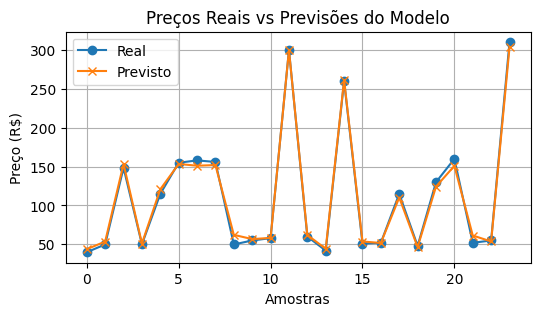

In [0]:
# Gráfico comparativo
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(resultados_ml['Real'].values, label='Real', marker='o')
plt.plot(resultados_ml['Previsto_RF'].values, label='Previsto', marker='x')
plt.title('Preços Reais vs Previsões do Modelo')
plt.xlabel('Amostras')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.show()

#                                                                          Deploy

In [0]:
# Recriar e treinar o modelo Random Forest
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Recarregar os dados
gold_df = spark.table("precificacao.db_precificacao.base_precificacao_gold")
pandas_df = gold_df.toPandas()

# Features seguras (sem vazamento)
features_seguras = ['ano', 'mes', 'produto_encoded', 'demanda', 'estoque', 'sazonalidade_encoded', 'estoque_baixo', 'demanda_alta']

# Separar features e target
X = pandas_df[features_seguras]
y = pandas_df['preco_atual']

# Treinar o modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
modelo_rf.fit(X, y)

print("Modelo Random Forest treinado com sucesso")

Modelo Random Forest treinado com sucesso


In [0]:
# Importar pandas
import pandas as pd

# Agora recriar a função de previsão
def prever_preco(produto, demanda, estoque, sazonalidade, mes, ano):
    """
    FUNÇÃO PARA PREVER PREÇO DE PRODUTOS
    Entrada: dados do produto e contexto de mercado
    Saída: preço sugerido pelo modelo
    """
    # Mapeamentos consistentes com o treino
    mapa_produtos = {
        'Camiseta Básica': 1, 
        'Calça Jeans': 2, 
        'Tênis Esportivo': 3, 
        'Moletom com Capuz': 4, 
        'Boné de Aba Reta': 5
    }
    
    mapa_sazonalidade = {
        'Baixa': 1, 
        'Média': 2, 
        'Alta': 3, 
        'Black Friday': 4
    }
    
    # Preparar os dados para o modelo
    dados_entrada = {
        'ano': [ano],
        'mes': [mes], 
        'produto_encoded': [mapa_produtos[produto]],
        'demanda': [demanda],
        'estoque': [estoque],
        'sazonalidade_encoded': [mapa_sazonalidade[sazonalidade]],
        'estoque_baixo': [1 if estoque < 100 else 0],
        'demanda_alta': [1 if demanda > 200 else 0]
    }
    
    # Converter para DataFrame
    df_entrada = pd.DataFrame(dados_entrada)
    
    # Fazer a previsão
    preco_previsto = modelo_rf.predict(df_entrada)
    
    return round(float(preco_previsto[0]), 2)

print("Função 'prever_preco' criada com sucesso")
print("Uso: prever_preco('Camiseta Básica', 200, 150, 'Alta', 12, 2024)")

Função 'prever_preco' criada com sucesso
Uso: prever_preco('Camiseta Básica', 200, 150, 'Alta', 12, 2024)


In [0]:
# Testar a função com alguns exemplos
try:
    # Teste 1
    preco1 = prever_preco('Camiseta Básica', 250, 80, 'Alta', 12, 2024)
    print(f"Preço Camiseta (Alta temporada): R$ {preco1}")
    
    # Teste 2  
    preco2 = prever_preco('Calça Jeans', 150, 200, 'Média', 6, 2024)
    print(f"Preço Calça (Média temporada): R$ {preco2}")
    
    # Teste 3
    preco3 = prever_preco('Tênis Esportivo', 350, 50, 'Black Friday', 11, 2024)
    print(f"Preço Tênis (Black Friday): R$ {preco3}")
    
except Exception as e:
    print(f"Erro ao testar função: {e}")

Preço Camiseta (Alta temporada): R$ 55.99
Preço Calça (Média temporada): R$ 154.13
Preço Tênis (Black Friday): R$ 305.7


In [0]:
# Análise comparativa das previsões
def analisar_previsao(produto, demanda, estoque, sazonalidade, mes, ano):
    """
    Função para analisar a previsão com comparações
    """
    # Fazer a previsão
    preco_previsto = prever_preco(produto, demanda, estoque, sazonalidade, mes, ano)
    
    # Encontrar preços históricos para comparação
    historico_produto = pandas_df[
        (pandas_df['produto_encoded'] == {'Camiseta Básica': 1, 'Calça Jeans': 2, 
                                         'Tênis Esportivo': 3, 'Moletom com Capuz': 4, 
                                         'Boné de Aba Reta': 5}[produto])
    ]
    
    # Calcular estatísticas históricas
    preco_medio_historico = historico_produto['preco_atual'].mean()
    preco_max_historico = historico_produto['preco_atual'].max()
    preco_min_historico = historico_produto['preco_atual'].min()
    
    # Encontrar preços na mesma sazonalidade
    sazonalidade_code = {'Baixa': 1, 'Média': 2, 'Alta': 3, 'Black Friday': 4}[sazonalidade]
    historico_sazonal = historico_produto[historico_produto['sazonalidade_encoded'] == sazonalidade_code]
    
    if not historico_sazonal.empty:
        preco_medio_sazonal = historico_sazonal['preco_atual'].mean()
    else:
        preco_medio_sazonal = preco_medio_historico
    
    print(f"=== ANÁLISE PARA {produto.upper()} ===")
    print(f"Preço previsto: R$ {preco_previsto:.2f}")
    print("")
    print("COMPARAÇÃO COM HISTÓRICO:")
    print(f"• Preço médio histórico: R$ {preco_medio_historico:.2f}")
    print(f"• Preço médio na {sazonalidade}: R$ {preco_medio_sazonal:.2f}")
    print(f"• Variação histórica: R$ {preco_min_historico:.2f} - R$ {preco_max_historico:.2f}")
    print("")
    
    # Análise de posicionamento
    diferenca_media = preco_previsto - preco_medio_sazonal
    if abs(diferenca_media) < 5:
        status = "ALINHADO com a média sazonal"
    elif diferenca_media > 0:
        status = f"ACIMA da média sazonal (+R$ {diferenca_media:.2f})"
    else:
        status = f"ABAIXO da média sazonal (R$ {abs(diferenca_media):.2f})"
    
    print(f"STATUS: {status}")
    print("=" * 50)
    print("")
    
    return preco_previsto

# Executar análise para os mesmos exemplos
print("ANÁLISE DETALHADA DAS PREVISÕES")
print("=" * 50)
print("")

preco1 = analisar_previsao('Camiseta Básica', 250, 80, 'Alta', 12, 2024)
preco2 = analisar_previsao('Calça Jeans', 150, 200, 'Média', 6, 2024)
preco3 = analisar_previsao('Tênis Esportivo', 350, 50, 'Black Friday', 11, 2024)

ANÁLISE DETALHADA DAS PREVISÕES

=== ANÁLISE PARA CAMISETA BÁSICA ===
Preço previsto: R$ 55.99

COMPARAÇÃO COM HISTÓRICO:
• Preço médio histórico: R$ 54.39
• Preço médio na Alta: R$ 56.55
• Variação histórica: R$ 49.90 - R$ 63.00

STATUS: ALINHADO com a média sazonal

=== ANÁLISE PARA CALÇA JEANS ===
Preço previsto: R$ 154.13

COMPARAÇÃO COM HISTÓRICO:
• Preço médio histórico: R$ 158.47
• Preço médio na Média: R$ 153.19
• Variação histórica: R$ 145.00 - R$ 176.00

STATUS: ALINHADO com a média sazonal

=== ANÁLISE PARA TÊNIS ESPORTIVO ===
Preço previsto: R$ 305.70

COMPARAÇÃO COM HISTÓRICO:
• Preço médio histórico: R$ 283.70
• Preço médio na Black Friday: R$ 320.00
• Variação histórica: R$ 249.90 - R$ 340.00

STATUS: ABAIXO da média sazonal (R$ 14.30)



In [0]:
def validar_previsao(produto, preco_previsto, preco_medio_historico):
    """
    FUNÇÃO PARA VALIDAR PREVISÕES COM REGRAS DE NEGÓCIO
    """
    # Definir limites por tipo de produto (em reais)
    limites_produtos = {
        'Camiseta Básica': {'min': 30.00, 'max': 80.00},
        'Calça Jeans': {'min': 100.00, 'max': 200.00},
        'Tênis Esportivo': {'min': 200.00, 'max': 350.00},
        'Moletom com Capuz': {'min': 80.00, 'max': 160.00},
        'Boné de Aba Reta': {'min': 35.00, 'max': 70.00}
    }
    
    # Obter limites do produto
    limites = limites_produtos.get(produto, {'min': 0, 'max': float('inf')})
    
    # Aplicar regras de validação
    validacoes = []
    
    # 1. Verificar se está dentro dos limites absolutos
    if preco_previsto < limites['min']:
        validacoes.append(f"ALERTA: Preço abaixo do mínimo (R$ {limites['min']})")
        preco_previsto = limites['min']
    elif preco_previsto > limites['max']:
        validacoes.append(f"ALERTA: Preço acima do máximo (R$ {limites['max']})")
        preco_previsto = limites['max']
    else:
        validacoes.append("✓ Dentro dos limites do produto")
    
    # 2. Verificar variação em relação à média histórica
    variacao_percentual = ((preco_previsto - preco_medio_historico) / preco_medio_historico) * 100
    
    if abs(variacao_percentual) > 30:
        validacoes.append(f"ALERTA: Variação de {variacao_percentual:.1f}% da média histórica")
    else:
        validacoes.append(f"✓ Variação de {variacao_percentual:.1f}% aceitável")
    
    # 3. Arredondar para múltiplo de 0.99 (prática comum no varejo)
    preco_final = round(preco_previsto) - 0.01
    
    return preco_final, validacoes

# Função completa com validação
def prever_preco_com_validacao(produto, demanda, estoque, sazonalidade, mes, ano):
    """
    FUNÇÃO COMPLETA COM PREVISÃO E VALIDAÇÃO
    """
    # Fazer previsão
    preco_previsto = prever_preco(produto, demanda, estoque, sazonalidade, mes, ano)
    
    # Calcular média histórica para validação
    historico_produto = pandas_df[
        (pandas_df['produto_encoded'] == {'Camiseta Básica': 1, 'Calça Jeans': 2, 
                                         'Tênis Esportivo': 3, 'Moletom com Capuz': 4, 
                                         'Boné de Aba Reta': 5}[produto])
    ]
    preco_medio_historico = historico_produto['preco_atual'].mean()
    
    # Validar previsão
    preco_final, validacoes = validar_previsao(produto, preco_previsto, preco_medio_historico)
    
    print(f"=== PREVISÃO VALIDADA PARA {produto.upper()} ===")
    print(f"Preço previsto inicial: R$ {preco_previsto:.2f}")
    print(f"Preço final validado: R$ {preco_final:.2f}")
    print("")
    print("VALIDAÇÕES:")
    for validacao in validacoes:
        print(f"• {validacao}")
    print("=" * 50)
    
    return preco_final

# Testar a função completa
print("TESTE DO SISTEMA COMPLETO COM VALIDAÇÃO")
print("=" * 50)
print("")

preco_validado1 = prever_preco_com_validacao('Camiseta Básica', 250, 80, 'Alta', 12, 2024)
print("")
preco_validado2 = prever_preco_com_validacao('Calça Jeans', 150, 200, 'Média', 6, 2024)

TESTE DO SISTEMA COMPLETO COM VALIDAÇÃO

=== PREVISÃO VALIDADA PARA CAMISETA BÁSICA ===
Preço previsto inicial: R$ 55.99
Preço final validado: R$ 55.99

VALIDAÇÕES:
• ✓ Dentro dos limites do produto
• ✓ Variação de 2.9% aceitável

=== PREVISÃO VALIDADA PARA CALÇA JEANS ===
Preço previsto inicial: R$ 154.13
Preço final validado: R$ 153.99

VALIDAÇÕES:
• ✓ Dentro dos limites do produto
• ✓ Variação de -2.7% aceitável


# Monitoramento


In [0]:
# Recriar as variáveis de teste e previsões
from sklearn.model_selection import train_test_split

# Certificar que temos os dados
gold_df = spark.table("precificacao.db_precificacao.base_precificacao_gold")
pandas_df = gold_df.toPandas()

# Features seguras
features_seguras = ['ano', 'mes', 'produto_encoded', 'demanda', 'estoque', 'sazonalidade_encoded', 'estoque_baixo', 'demanda_alta']

# Separar dados
X = pandas_df[features_seguras]
y = pandas_df['preco_atual']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Fazer previsões novamente
y_previsto_rf = modelo_rf.predict(X_teste)

print("Variáveis y_teste e y_previsto_rf recriadas")
print(f"y_teste shape: {y_teste.shape}")
print(f"y_previsto_rf shape: {y_previsto_rf.shape}")

Variáveis y_teste e y_previsto_rf recriadas
y_teste shape: (24,)
y_previsto_rf shape: (24,)


In [0]:
# Preparar dados para dashboard
from sklearn.metrics import mean_absolute_error, r2_score

def preparar_dados_dashboard():
    dashboard_data = pd.DataFrame({
        'data': pandas_df['Data'],
        'produto': pandas_df['produto_encoded'].map({
            1: 'Camiseta Básica', 
            2: 'Calça Jeans', 
            3: 'Tênis Esportivo',
            4: 'Moletom com Capuz', 
            5: 'Boné de Aba Reta'
        }),
        'preco_real': pandas_df['preco_atual'],
        'sazonalidade': pandas_df['sazonalidade_encoded'].map({
            1: 'Baixa', 
            2: 'Média', 
            3: 'Alta', 
            4: 'Black Friday'
        }),
        'demanda': pandas_df['demanda'],
        'estoque': pandas_df['estoque']
    })
    
    performance = {
        'mae': mean_absolute_error(y_teste, y_previsto_rf),
        'r2': r2_score(y_teste, y_previsto_rf),
        'total_previsoes': len(y_previsto_rf)
    }
    
    return dashboard_data, performance

dados_dashboard, metricas = preparar_dados_dashboard()
print("Dados preparados para dashboard")

Dados preparados para dashboard


DASHBOARD DE MONITORAMENTO
Performance do Modelo:
MAE: 1.74
R²: 0.9989
Total de previsoes: 24



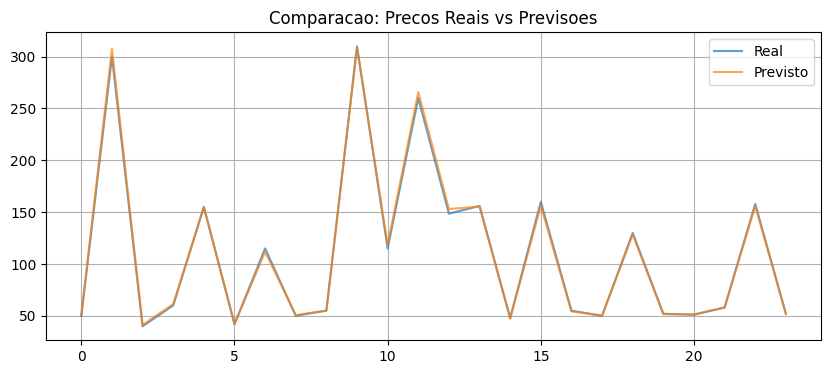

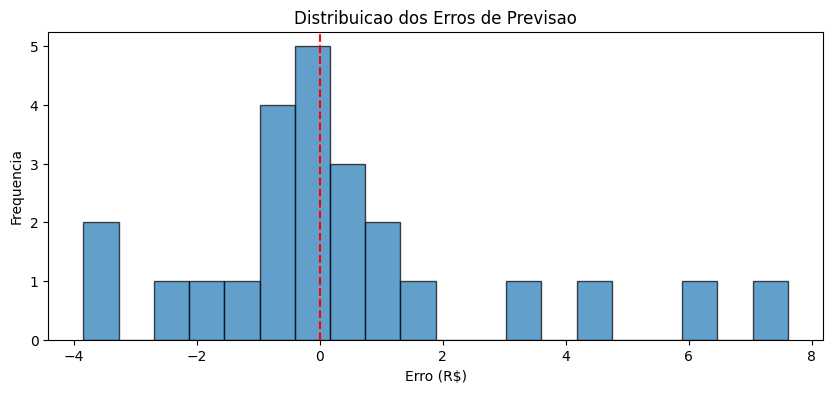

In [0]:
import matplotlib.pyplot as plt

print("DASHBOARD DE MONITORAMENTO")
print("Performance do Modelo:")
print(f"MAE: {metricas['mae']:.2f}")
print(f"R²: {metricas['r2']:.4f}")
print(f"Total de previsoes: {metricas['total_previsoes']}")
print("")

# Grafico 1: Precos Reais vs Previstos
plt.figure(figsize=(10, 4))
plt.plot(y_teste.values, label='Real', alpha=0.7)
plt.plot(y_previsto_rf, label='Previsto', alpha=0.7)
plt.title('Comparacao: Precos Reais vs Previsoes')
plt.legend()
plt.grid(True)
plt.show()

# Grafico 2: Distribuicao de Erros
plt.figure(figsize=(10, 4))
erros = y_previsto_rf - y_teste.values
plt.hist(erros, bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribuicao dos Erros de Previsao')
plt.xlabel('Erro (R$)')
plt.ylabel('Frequencia')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

In [0]:
import joblib

# Salvar o modelo em arquivo
joblib.dump(modelo_rf, 'modelo_precificacao_rf.pkl')
print("Modelo salvo como 'modelo_precificacao_rf.pkl'")

# Salvar os mapeamentos necessários
mapeamentos = {
    'produtos': {'Camiseta Básica': 1, 'Calça Jeans': 2, 'Tênis Esportivo': 3, 'Moletom com Capuz': 4, 'Boné de Aba Reta': 5},
    'sazonalidade': {'Baixa': 1, 'Média': 2, 'Alta': 3, 'Black Friday': 4}
}

joblib.dump(mapeamentos, 'mapeamentos_modelo.pkl')
print("Mapeamentos salvos como 'mapeamentos_modelo.pkl'")

Modelo salvo como 'modelo_precificacao_rf.pkl'
Mapeamentos salvos como 'mapeamentos_modelo.pkl'


In [0]:
# Salvar função de previsão em arquivo Python
codigo_funcao = '''
import pandas as pd
import joblib

def prever_preco(produto, demanda, estoque, sazonalidade, mes, ano):
    """Função para prever preço de produtos"""
    # Carregar modelo e mapeamentos
    modelo = joblib.load('modelo_precificacao_rf.pkl')
    mapeamentos = joblib.load('mapeamentos_modelo.pkl')
    
    # Preparar dados de entrada
    dados_entrada = {
        'ano': [ano],
        'mes': [mes], 
        'produto_encoded': [mapeamentos['produtos'][produto]],
        'demanda': [demanda],
        'estoque': [estoque],
        'sazonalidade_encoded': [mapeamentos['sazonalidade'][sazonalidade]],
        'estoque_baixo': [1 if estoque < 100 else 0],
        'demanda_alta': [1 if demanda > 200 else 0]
    }
    
    df_entrada = pd.DataFrame(dados_entrada)
    preco_previsto = modelo.predict(df_entrada)
    
    return round(float(preco_previsto[0]), 2)
'''

with open('funcao_precificacao.py', 'w') as f:
    f.write(codigo_funcao)
print("Função salva como 'funcao_precificacao.py'")

Função salva como 'funcao_precificacao.py'


In [0]:
# Script para monitoramento periódico
def monitorar_performance(novos_dados, novos_precos_reais):
    """
    Função para monitorar performance do modelo ao longo do tempo
    """
    # Fazer previsões para novos dados
    previsoes = modelo_rf.predict(novos_dados)
    
    # Calcular métricas atuais
    mae_atual = mean_absolute_error(novos_precos_reais, previsoes)
    r2_atual = r2_score(novos_precos_reais, previsoes)
    
    # Comparar com baseline
    degradacao_mae = ((mae_atual - 1.74) / 1.74) * 100  # 1.74 é o MAE original
    
    print(f"MAE atual: {mae_atual:.2f} ({degradacao_mae:+.1f}% vs baseline)")
    print(f"R² atual: {r2_atual:.4f}")
    
    # Alertas
    if degradacao_mae > 20:
        print("ALERTA: Performance degradou significativamente")
    if r2_atual < 0.95:
        print("ALERTA: Poder explicativo abaixo do esperado")

In [0]:
# Estratégia de re-treinamento
plano_retreinamento = {
    'periodicidade': 'trimestral',
    'gatilhos': [
        'MAE aumentar mais de 20%',
        'R² cair abaixo de 0.95', 
        'Mudança significativa no padrão dos dados',
        'Lançamento de novos produtos'
    ],
    'acoes': [
        'Coletar novos dados',
        'Re-treinar modelo',
        'Validar performance',
        'Substituir modelo em produção'
    ]
}

print("Plano de re-treinamento definido:")
for key, value in plano_retreinamento.items():
    print(f"{key}: {value}")

Plano de re-treinamento definido:
periodicidade: trimestral
gatilhos: ['MAE aumentar mais de 20%', 'R² cair abaixo de 0.95', 'Mudança significativa no padrão dos dados', 'Lançamento de novos produtos']
acoes: ['Coletar novos dados', 'Re-treinar modelo', 'Validar performance', 'Substituir modelo em produção']


In [0]:
# Instalar a biblioteca para trabalhar com Excel
%pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Reiniciar o kernel Python para carregar as novas bibliotecas
dbutils.library.restartPython()
print("Kernel Python reiniciado - bibliotecas disponíveis")

Kernel Python reiniciado - bibliotecas disponíveis


In [0]:
# Recriar a função prever_preco (versão completa)
def prever_preco(produto, demanda, estoque, sazonalidade, mes, ano):
    # Mapeamentos
    mapa_produtos = {
        'Camiseta Básica': 1, 
        'Calça Jeans': 2, 
        'Tênis Esportivo': 3, 
        'Moletom com Capuz': 4, 
        'Boné de Aba Reta': 5
    }
    
    mapa_sazonalidade = {
        'Baixa': 1, 
        'Média': 2, 
        'Alta': 3, 
        'Black Friday': 4
    }
    
    # Preparar dados
    dados_entrada = {
        'ano': [ano],
        'mes': [mes], 
        'produto_encoded': [mapa_produtos[produto]],
        'demanda': [demanda],
        'estoque': [estoque],
        'sazonalidade_encoded': [mapa_sazonalidade[sazonalidade]],
        'estoque_baixo': [1 if estoque < 100 else 0],
        'demanda_alta': [1 if demanda > 200 else 0]
    }
    
    df_entrada = pd.DataFrame(dados_entrada)
    preco_previsto = modelo_rf.predict(df_entrada)
    
    return round(float(preco_previsto[0]), 2)

print("Função prever_preco recriada com sucesso")

Função prever_preco recriada com sucesso


In [0]:
# Recarregar modelo e variáveis necessárias
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Recarregar dados
gold_df = spark.table("precificacao.db_precificacao.base_precificacao_gold")
pandas_df = gold_df.toPandas()

# Recriar modelo (usando mesmos parâmetros)
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)

# Features e target
features_seguras = ['ano', 'mes', 'produto_encoded', 'demanda', 'estoque', 'sazonalidade_encoded', 'estoque_baixo', 'demanda_alta']
X = pandas_df[features_seguras]
y = pandas_df['preco_atual']

# Treinar modelo
modelo_rf.fit(X, y)

print("Modelo rf recriado e treinado com sucesso")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff18cb6deac0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Modelo rf recriado e treinado com sucesso


In [0]:
# Criar previsões REAIS com seu modelo
import pandas as pd
from datetime import datetime

# Dados NOVOS para previsão (exemplos)
novos_dados = [
    {'produto': 'Camiseta Básica', 'demanda': 250, 'estoque': 80, 'sazonalidade': 'Alta', 'mes': 12, 'ano': 2024},
    {'produto': 'Calça Jeans', 'demanda': 180, 'estoque': 150, 'sazonalidade': 'Média', 'mes': 6, 'ano': 2024},
    {'produto': 'Tênis Esportivo', 'demanda': 220, 'estoque': 90, 'sazonalidade': 'Black Friday', 'mes': 11, 'ano': 2024}
]

# Fazer previsões REAIS
previsoes_reais = []
for dado in novos_dados:
    preco_previsto = prever_preco(
        produto=dado['produto'],
        demanda=dado['demanda'],
        estoque=dado['estoque'],
        sazonalidade=dado['sazonalidade'],
        mes=dado['mes'],
        ano=dado['ano']
    )
    
    previsoes_reais.append({
        'produto': dado['produto'],
        'demanda': dado['demanda'],
        'estoque': dado['estoque'],
        'sazonalidade': dado['sazonalidade'],
        'mes': dado['mes'],
        'ano': dado['ano'],
        'preco_sugerido': preco_previsto,
        'data_previsao': datetime.now()
    })

# Criar DataFrame com previsões REAIS
previsoes_df = pd.DataFrame(previsoes_reais)
print("Previsões reais geradas com sucesso")
display(previsoes_df)

Previsões reais geradas com sucesso


produto,demanda,estoque,sazonalidade,mes,ano,preco_sugerido,data_previsao
Camiseta Básica,250,80,Alta,12,2024,55.99,2025-09-05T19:21:29.331Z
Calça Jeans,180,150,Média,6,2024,155.39,2025-09-05T19:21:29.335Z
Tênis Esportivo,220,90,Black Friday,11,2024,296.03,2025-09-05T19:21:29.340Z


In [0]:
# Converter a lista para DataFrame antes de exportar
previsoes_df = pd.DataFrame(previsoes_reais)

# Exportar para Excel
previsoes_df.to_excel('precificacoes_sugeridas.xlsx', index=False, engine='openpyxl')
print("Arquivo 'precificacoes_sugeridas.xlsx' exportado com sucesso")

# Mostrar preview dos dados exportados
print("Dados exportados:")
display(previsoes_df)

Arquivo 'precificacoes_sugeridas.xlsx' exportado com sucesso
Dados exportados:


produto,demanda,estoque,sazonalidade,mes,ano,preco_sugerido,data_previsao
Camiseta Básica,250,80,Alta,12,2024,55.99,2025-09-05T19:21:29.331Z
Calça Jeans,180,150,Média,6,2024,155.39,2025-09-05T19:21:29.335Z
Tênis Esportivo,220,90,Black Friday,11,2024,296.03,2025-09-05T19:21:29.340Z


In [0]:
# VERIFICAR se o arquivo Excel foi criado
import os

if os.path.exists('precificacoes_sugeridas.xlsx'):
    print("Arquivo Excel criado com sucesso!")
    print(f"Caminho: {os.path.abspath('precificacoes_sugeridas.xlsx')}")
    print(f"Tamanho: {os.path.getsize('precificacoes_sugeridas.xlsx')} bytes")
    
    # Opcional: ler e mostrar o conteúdo para confirmar
    df_verificado = pd.read_excel('precificacoes_sugeridas.xlsx', engine='openpyxl')
    print("\nConteúdo do arquivo:")
    display(df_verificado)
    
else:
    print("Arquivo não foi criado - verifique possíveis erros")

Arquivo Excel criado com sucesso!
Caminho: /Workspace/projeto_precificacao/precificacoes_sugeridas.xlsx
Tamanho: 5294 bytes

Conteúdo do arquivo:


produto,demanda,estoque,sazonalidade,mes,ano,preco_sugerido,data_previsao
Camiseta Básica,250,80,Alta,12,2024,55.99,2025-09-05T19:21:29.332Z
Calça Jeans,180,150,Média,6,2024,155.39,2025-09-05T19:21:29.336Z
Tênis Esportivo,220,90,Black Friday,11,2024,296.03,2025-09-05T19:21:29.340Z
